In [27]:
# Domain [mm]
x_max = 1

using QuadGK
using Interpolations

# Elliptic extension of a vessel
function vessel(t)
    # Straight line parameters and starting point
    line_len = 1/4
    start_pos = 1/4
    # Ellipse curve parameters
    x_semiax = x_max - start_pos*x_max
    y_semiax = x_max - line_len*x_max
    max_t = 2 
    # when straight line
    if t < line_len*x_max
        return (start_pos*x_max, t)
    end
    # else, the ellipse
    tt = t - line_len*x_max
    ellipse_curve(tt) = (-x_semiax*cos(tt) + x_semiax, y_semiax*sin(tt))
    # We seek to obtain the parametrization with speed one.
    curve_deriv(tt) = (x_semiax*sin(tt), y_semiax*cos(tt))
    deriv_norm(tt) = sqrt(curve_deriv(tt)[1]^2 + curve_deriv(tt)[2]^2)
    arclength(tt) = quadgk(deriv_norm, 0, tt)
        # we invert the arclength
    t_sample = [t for t = linspace(0,max_t,1000)]
    arclength_sample = [arclength(t)[1] for t in t_sample]
    inv_interp = LinearInterpolation(arclength_sample, t_sample)
    natural_curve(tt) = ellipse_curve(inv_interp(tt))
    x0 = start_pos*x_max
    y0 = line_len*x_max
    return (natural_curve(tt)[1] + x0, natural_curve(tt)[2] + y0) 
end

using Roots

target_funct(t) = max(vessel(t)[1] - x_max*0.9, vessel(t)[2] - x_max*0.9)
impossible_time = 1.5
lower_time = 0
if target_funct(lower_time)*target_funct(impossible_time) > 0
    print("This is not going to work")
end
t_max = find_zero(target_funct, (lower_time, impossible_time), Bisection())


vessel (generic function with 1 method)

# Bruillon grounds ahead, thread carefully

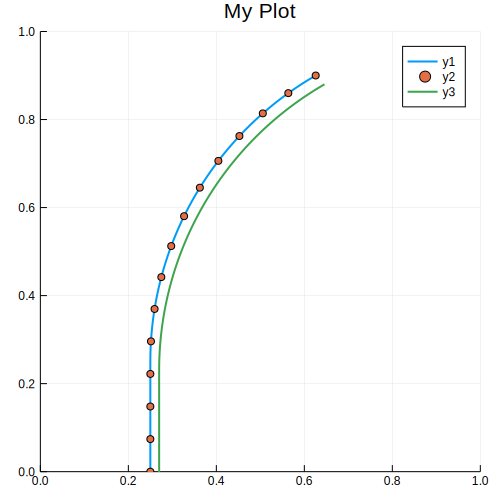

In [40]:
# Plotting cell
T = linspace(0,t_max,1000)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] for j in 1:length(Y)]
Yy = [Y[j][2] for j in 1:length(Y)]

using Plots
plot(Yx,Yy,linewidth=2,title="My Plot" , xlims = (0,x_max), ylims = (0,x_max), size = (500,500))

T = linspace(0,t_max, 15)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] for j in 1:length(Y)]
Yy = [Y[j][2] for j in 1:length(Y)]
plot!(Yx,Yy, seriestype=:scatter)

# Testing by displacing the curve
dx = 0.02
T = linspace(0,t_max,1000)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] + dx for j in 1:length(Y)]
Yy = [Y[j][2] - dx for j in 1:length(Y)]
plot!(Yx,Yy, linewidth=2)

In [21]:
# Trying to integrate the curvature such that the step is constant. 

using QuadGK
vessel_norm(t) = sqrt(vessel(t)[1]^2 + vessel(t)[2]^2)
s(t) = quadgk(vessel_norm,0.25, t)
s(1)[1]
s(2)[1]

1.673737650147885

In [26]:
using Interpolations
tt = [t for t = linspace(0,1,1000)]
st = [s(t)[1] for t in tt]
interp = LinearInterpolation(tt,st)
interp(0.5)
interp(0.6)

0.16257557775815573

In [35]:
# Find the maximum relevant time, when we are getting too close to the boundary.
using Roots

target_funct(t) = max(vessel(t)[1] - x_max*0.9, vessel(t)[2] - x_max*0.9)
impossible_time = 1.5
lower_time = 0
if target_funct(lower_time)*target_funct(impossible_time) > 0
    print("This is not going to work")
end
t_max = find_zero(target_funct, (lower_time, impossible_time), Bisection())

1.036361128741636

# Writting down the vessel generator function

In [2]:
using Interpolations
using Roots
using QuadGK

type TreeNode
    parent::Int
    children::Vector{Int}
    curveData::Array{Any,1}
end
type Tree
    nodes::Vector{TreeNode}
end
Tree(data) = Tree([TreeNode(0, Vector{Int}(), data)])
function addchild(tree::Tree, id::Int, curveData::Array{Any,1})
    1 <= id <= length(tree.nodes) || throw(BoundsError(tree, id))
    push!(tree.nodes, TreeNode(id, Vector{}(), curveData))
    child = length(tree.nodes)
    push!(tree.nodes[id].children, child)
    child
end
children(tree, id) = tree.nodes[id].children
parent(tree,id) = tree.nodes[id].parent
data(tree,id) = tree.nodes[id].curveData

function angle_direction(direction)
    return pi/2 - atan(direction[2],direction[1])
end

function segment_generator(Vessel, id)
    parameters = data(Vessel,id)
    x0 = parameters[1]
    tf = parameters[2]
    angle = parameters[3]
    speed = parameters[4]
    curve_type = parameters[5]
    params = parameters[6]
    if curve_type == "straight"
        f  = t -> [0 ; t]
        df = t -> [0 ; 1]
    elseif curve_type == "ellipse"
        if length(params)!= 3
            error("Incorrect number of input parameters")
        end
        side = params[1]
        x_semiax = params[2]
        y_semiax = params[3]
        g(t) = [x_semiax*(1-cos(t))*side; y_semiax*sin(t)]
        dg(t) = [x_semiax*side*sin(t); y_semiax*cos(t) ]
        # now we need to obtain the natural parametrization
            norm_derivative(t) = sqrt(dg(t)[1]^2 + dg(t)[2]^2)
            arclength(t) = quadgk(norm_derivative, 0, t)
            # invert the arc length
            max_sample = 1
            while arclength(max_sample)[1]-tf < 0
                max_sample = max_sample*2
            end
            t_sample = [t for t = linspace(0,max_sample,1000)]
            arclength_sample = [arclength(t)[1] for t in t_sample]
            inv_interp = LinearInterpolation(arclength_sample, t_sample)
        f = t -> g(inv_interp(t))
        df = t-> dg(inv_interp(t))/sqrt( dg(inv_interp(t))[1]^2 + dg(inv_interp(t))[2]^2 )
    else
        error("Not a valid curve type, find the correct names")
    end
    # Rotation matrix
    rotation_mat = [cos(angle) -sin(angle); sin(angle) cos(angle)]
    # Translation, speed scalation, rotation
    segment(t) = rotation_mat*f(t*speed) + x0
    dsegment(t) = rotation_mat*df(t*speed)
    return [segment , dsegment]
end

segment_generator (generic function with 1 method)

In [3]:
# Building the vessel network
x0 = [0.1,0.1]
# arrays of t_max, relative direction, curve_type, parameters
curve1 = [0.3, -pi/6,1, "straight", [] ]
curve2 = [0.4, 0,1,"ellipse", [1,2,0.5]]
curve3 = [0.55, 0,1, "ellipse", [-1,2,1]]
curve4 = [0.45, pi/2,1, "ellipse", [-1,2,1]]
curve5 = [0.35, 0,1, "ellipse", [1,2,1]]

# This tree has only relative information

Vessel = Tree(curve1)      #curve 1
addchild(Vessel,1, curve2) #curve 2
addchild(Vessel,1, curve3) #curve 3
addchild(Vessel,2, curve4) #curve 4
addchild(Vessel,2, curve5) #curve 5

function Absolute_Vessel(Vessel,id, x0, angle)
    datta = data(Vessel,id)
    datta[2] = datta[2]-angle
    prepend!(datta,[x0])
    Vessel.nodes[id].curveData = datta
    segt, dsegt = segment_generator(Vessel, id)
    new_angle = angle_direction(dsegt(datta[2]))
    new_position = segt(datta[2])
    for j in children(Vessel,id)
        Absolute_Vessel(Vessel,j, new_position, new_angle)
    end
end

Absolute_Vessel(Vessel, 1, x0, 0)


In [8]:

using Plots

function plot_vessel(Vessel, id)
    curve, _ = segment_generator(Vessel, id)
    x_max = 1
    T = linspace(0,data(Vessel,id)[2],1000)
    Y = [curve(t) for t in T]
    Yx = [Y[j][1] for j in 1:length(Y)]
    Yy = [Y[j][2] for j in 1:length(Y)]
    if id==1
        plot(Yx,Yy,linewidth=2,title="Curves" , xlims = (0,x_max), ylims = (0,x_max), size = (500,500))
    else
        plot!(Yx,Yy,linewidth=2,title="Curves" , xlims = (0,x_max), ylims = (0,x_max), size = (500,500))
    end
end

plot_vessel (generic function with 1 method)

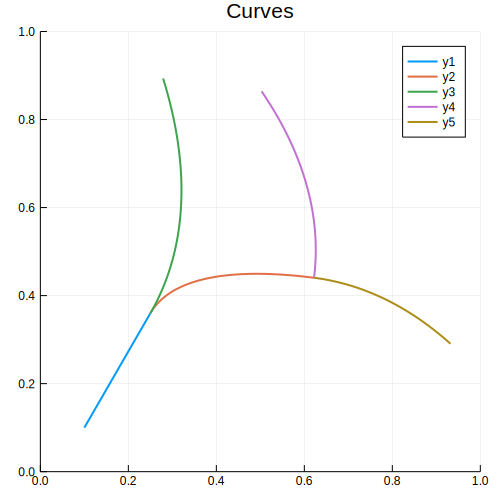

In [13]:
#for i = 1:length(Vessel.nodes)
#    plot_vessel(data(Vessel,i),i)
#end
i=5
plot_vessel(Vessel,i)

In [16]:
function displacement(Vessel, id, t, dt)
    # This method is not robust to big displacements ! 
    tf = data(Vessel,id)[2]
    if 0 <= t+dt && t+dt <= tf
        return (id, t+dt)
    elseif t+dt > tf
        next_vessel = children(Vessel,id)
        if isempty(next_vessel)
            return NaN
        else
        # Choose some children at random, assuming at most 2
            new_id = next_vessel[rand(1:2)]
            return (new_id, t+dt-tf)
        end
    else
        # backward case, t+dt < 0 
        new_id = parent(Vessel,id)
        if new_id == 0
            return NaN
        else
            new_tf = data(Vessel,new_id)[2]
            return (new_id, new_tf+t+dt)
        end
    end
end

function evaluation(Vessel, id, t)
    segt, _ = segment_generator(Vessel, id)
    return segt(t)
end


evaluation (generic function with 1 method)

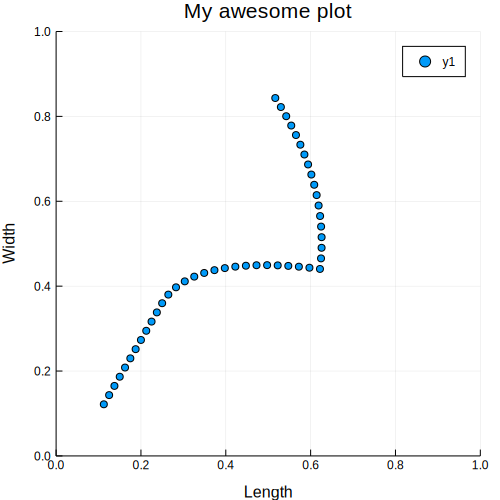

In [20]:
x_max = 1
particle = (1,0.0)
dt = 0.025
particle = displacement(Vessel, particle[1], particle[2], dt)
position = evaluation(Vessel,particle[1],particle[2])

registered_x = []
registered_y = []
while isnan(particle[1]) == false
    position = evaluation(Vessel,particle[1],particle[2])
    push!(registered_x, position[1])
    push!(registered_y, position[2])
    particle = displacement(Vessel, particle[1], particle[2], dt)
end

scatter(registered_x,registered_y,
title = "My awesome plot",
        xlabel = "Length", ylabel = "Width",xlims = (0,x_max), ylims = (0,x_max), size = (500,500))


In [60]:
isnan(particle)

true

In [80]:
# Uniform samples on the network
function Uniform_sampler(Vessel)
    times = []
    for id =1:length(Vessel.nodes)
        append!(times, data(Vessel,id)[2])
    end
    tot_time = sum(times)
    selector = rand()*tot_time
    for i=1:length(times)
        if selector < times[i]
            return (i, selector)
        else
            selector = selector - times[i]
        end
    end
end

pos = Uniform_sampler(Vessel)
println(pos)
println(data(Vessel,pos[1])[2])

(4, 0.4407854754397601)
0.45


In [28]:
rand()*2.3


0.2317295567707042

In [81]:
(1,(1,2))

(1, (1, 2))